<h1><center>Random Forest Project</h1></center>

For this project we will be exploring publicly available data from [LendingClub.com](www.lendingclub.com). Lending Club connects people who need money (borrowers) with people who have money (investors). Hopefully, as an investor you would want to invest in people who showed a profile of having a high probability of paying you back. We will try to create a model that will help predict this.

Lending club had a [very interesting year in 2016](https://en.wikipedia.org/wiki/Lending_Club#2016), so let's check out some of their data and keep the context in mind. This data is from before they even went public.

We will use lending data from 2007-2010 and be trying to classify and predict whether or not the borrower paid back their loan in full. You can download the data from [here](https://www.lendingclub.com/info/download-data.action) or just use the csv already provided. It's recommended you use the csv provided as it has been cleaned of NA values.

Here are what the columns represent:
* credit.policy: 1 if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise.
* purpose: The purpose of the loan (takes values "credit_card", "debt_consolidation", "educational", "major_purchase", "small_business", and "all_other").
* int.rate: The interest rate of the loan, as a proportion (a rate of 11% would be stored as 0.11). Borrowers judged by LendingClub.com to be more risky are assigned higher interest rates.
* installment: The monthly installments owed by the borrower if the loan is funded.
* log.annual.inc: The natural log of the self-reported annual income of the borrower.
* dti: The debt-to-income ratio of the borrower (amount of debt divided by annual income).
* fico: The FICO credit score of the borrower.
* days.with.cr.line: The number of days the borrower has had a credit line.
* revol.bal: The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle).
* revol.util: The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available).
* inq.last.6mths: The borrower's number of inquiries by creditors in the last 6 months.
* delinq.2yrs: The number of times the borrower had been 30+ days past due on a payment in the past 2 years.
* pub.rec: The borrower's number of derogatory public records (bankruptcy filings, tax liens, or judgments).

# Import Libraries

**Import the usual libraries for pandas and plotting. You can import sklearn later on.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# RAMDOM FOREST => BASED ON CENTRAL LIMIT THEOREM
[Link for explanation](https://towardsdatascience.com/random-forests-and-the-bias-variance-tradeoff-3b77fee339b4)
Decision Trees have extremely low bias because they maximally overfit to the training data. Each “prediction” it makes on the validation set would in essence be the fare of some taxi ride in our training data that ended up in the same final leaf node as the ride whose fare we are predicting.
This overfitting, however, also results in unacceptably high variance and consequently poor predictions on unseen data.

While an individual tree is overfit to the training data and is likely to have large error, bagging (Bootstrap Aggregating) uses the insight that a suitably large number of uncorrelated errors average out to zero to solve this problem. Bagging chooses multiple random samples of observations from the training data, with replacement, constructing a tree from each one. Since each tree learns from different data, they are fairly uncorrelated from one another. Plotting the R² of our model as we increase the number of “bagged” trees ( scikit-learn calls these trees estimators) illustrates the power of this technique.

In the lecture we get the following information:[blog post](https://medium.com/@josemarcialportilla/enchanted-random-forest-b08d418cb411#.hh7n1co54) 

When the data is split 50-50, then we have maximum uncertainty about the data.

On the other hand, if we have 0 or 1 probability (or percentage of the data),

then we have no uncertainty at all (0).

The equations are:
entropy(x) = -x*log2(x)-(1-x)*log2(1-x)
gini(x) = 1-x^2-(1-x)^2


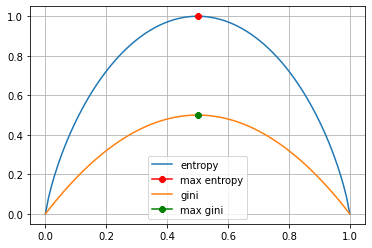

In [2]:
plt.grid()
x = np.linspace(1e-8,1-1e-8,100)
entropy = lambda x: -1*x*(np.log2(x))-(1-x)*(np.log2(1-x))
gini = lambda x: 1-x**2 -(1-x)**2
plt.plot(x,entropy(x),[0.5],[1],'8r-',x,gini(x),[0.5],[0.5],'8g-')
plt.legend(['entropy','max entropy','gini','max gini'])
print('''When the data is split 50-50, then we have maximum uncertainty about the data.\n
On the other hand, if we have 0 or 1 probability (or percentage of the data),\n
then we have no uncertainty at all (0).\n
The equations are:
entropy(x) = -x*log2(x)-(1-x)*log2(1-x)
gini(x) = 1-x^2-(1-x)^2''')

## Get the Data

**Use pandas to read loan_data.csv as a dataframe called loans.**

In [3]:
loans = pd.read_csv('loan_data.csv')

**Check out the info(), head(), and describe() methods on loans.**

In [4]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [5]:
loans.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.804970,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.163708,0.062122,0.160054
std,0.396245,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.546215,0.262126,0.366676
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000


In [6]:
loans.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


# Exploratory Data Analysis

** Histogram of two FICO distributions on top of each other, one for each credit.policy outcome.**


In [7]:
#sns.pairplot(loans)

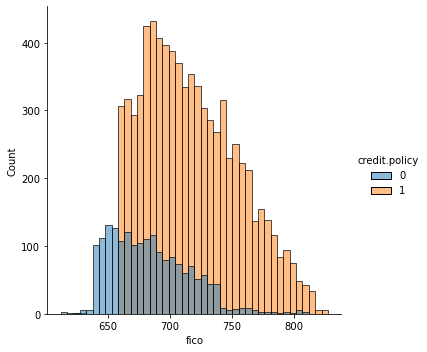

In [8]:
sns.displot(loans,x='fico',hue='credit.policy')

** Select by the not.fully.paid column.**

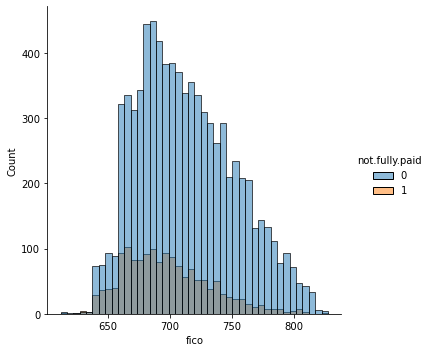

In [9]:
sns.displot(loans,x='fico',hue='not.fully.paid')

** Countplot showing the counts of loans by purpose, with the color hue defined by not.fully.paid. **

<AxesSubplot:xlabel='purpose', ylabel='count'>

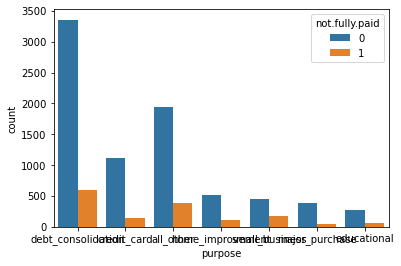

In [10]:
sns.countplot(data=loans,x='purpose',hue='not.fully.paid')

** Let's see the trend between FICO score and interest rate.**

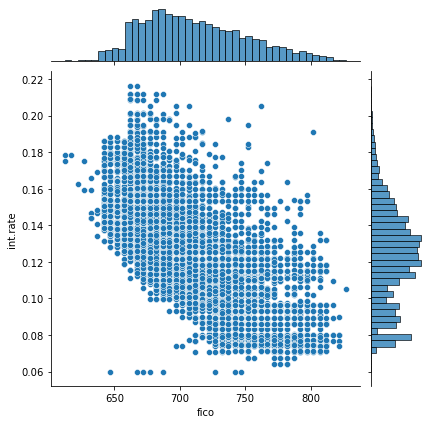

In [11]:
sns.jointplot(data=loans,x='fico',y='int.rate')

**Plots to see if the trend differed between not.fully.paid and credit.policy.**

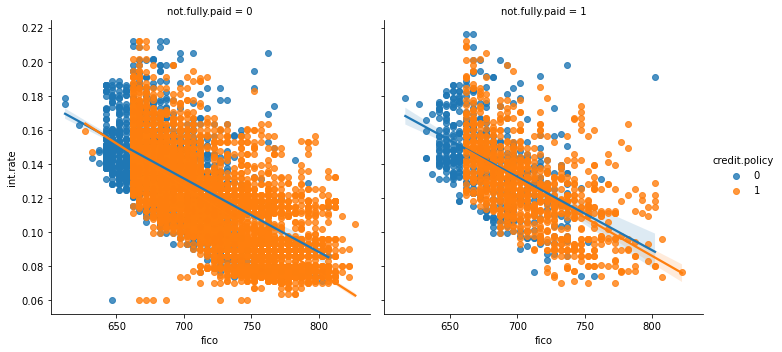

In [12]:
loans.head(1)
sns.lmplot(data=loans,x='fico',y='int.rate',hue='credit.policy',col='not.fully.paid')
#plt.figure(figsize=(11,7))
#sns.lmplot(y='int.rate',x='fico',data=loans,hue='credit.policy',
#           col='not.fully.paid',palette='Set1')

# Setting up the Data

Let's get ready to set up our data for our Random Forest Classification Model!

**Check loans.info() again.**

In [13]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


## Categorical Features

Notice that the **purpose** column as categorical

That means we need to transform them using dummy variables so sklearn will be able to understand them. Let's do this in one clean step using pd.get_dummies.

Let's show you a way of dealing with these columns that can be expanded to multiple categorical features if necessary.

**Create a list of 1 element containing the string 'purpose'. Call this list cat_feats.**

In [14]:
loans.purpose.value_counts()
#final_data = pd.get_dummies(data=loans['purpose'],drop_first=True)#,columns=['purpose'])
final_data = pd.get_dummies(loans,columns=['purpose'],drop_first=True)

**Now use pd.get_dummies(loans,columns=cat_feats,drop_first=True) to create a fixed larger dataframe that has new feature columns with dummy variables. Set this dataframe as final_data.**

In [15]:
final_data.info()
#loans

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   credit.policy               9578 non-null   int64  
 1   int.rate                    9578 non-null   float64
 2   installment                 9578 non-null   float64
 3   log.annual.inc              9578 non-null   float64
 4   dti                         9578 non-null   float64
 5   fico                        9578 non-null   int64  
 6   days.with.cr.line           9578 non-null   float64
 7   revol.bal                   9578 non-null   int64  
 8   revol.util                  9578 non-null   float64
 9   inq.last.6mths              9578 non-null   int64  
 10  delinq.2yrs                 9578 non-null   int64  
 11  pub.rec                     9578 non-null   int64  
 12  not.fully.paid              9578 non-null   int64  
 13  purpose_credit_card         9578 

## Train Test Split

Now its time to split our data into a training set and a testing set!

**Use sklearn to split your data into a training set and a testing set as we've done in the past.**

In [16]:
from sklearn import model_selection

In [17]:
X = final_data.drop('not.fully.paid',axis=1)
y = final_data['not.fully.paid']

In [18]:
#model_selection.train_test_split()
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=42)

In [19]:
X_train.columns

Index(['credit.policy', 'int.rate', 'installment', 'log.annual.inc', 'dti',
       'fico', 'days.with.cr.line', 'revol.bal', 'revol.util',
       'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_educational',
       'purpose_home_improvement', 'purpose_major_purchase',
       'purpose_small_business'],
      dtype='object')

## Training a Decision Tree Model

Let's start by training a single decision tree first!

**Import DecisionTreeClassifier**

In [20]:
from sklearn.tree import DecisionTreeClassifier

**Create an instance of DecisionTreeClassifier() called dtree and fit it to the training data.**

In [21]:
dtree = DecisionTreeClassifier()

In [22]:
dtree.fit(X_train,y_train)

DecisionTreeClassifier()

## Predictions and Evaluation of Decision Tree
**Create predictions from the test set and create a classification report and a confusion matrix.**

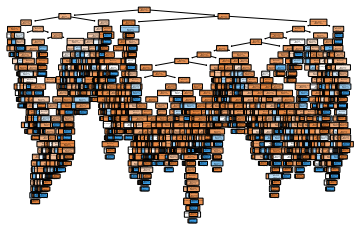

In [23]:
from sklearn import tree
tree.plot_tree(dtree,
            feature_names=X.columns,
            #class_names=sorted(y.unique()),
            #label='all',
            rounded=True,
            #fontsize=
            filled=True);

In [24]:
y_pred = dtree.predict(X_test)

In [25]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test,y_pred),'\n')
print(metrics.classification_report(y_test,y_pred))

[[2239  411]
 [ 396  115]] 

              precision    recall  f1-score   support

           0       0.85      0.84      0.85      2650
           1       0.22      0.23      0.22       511

    accuracy                           0.74      3161
   macro avg       0.53      0.53      0.53      3161
weighted avg       0.75      0.74      0.75      3161



## Training the Random Forest model

Now its time to train our model!

**Create an instance of the RandomForestClassifier class and fit it to our training data from the previous step.**

**Predict the class of not.fully.paid for the X_test data.**

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
rf = RandomForestClassifier(n_estimators=300)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

**Now create a classification report from the results and a confusion matrix. Do you get anything strange or some sort of warning?**

In [28]:
print(metrics.confusion_matrix(y_test,y_pred),'\n')
print(metrics.classification_report(y_test,y_pred),'\n')

[[2637   13]
 [ 505    6]] 

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      2650
           1       0.32      0.01      0.02       511

    accuracy                           0.84      3161
   macro avg       0.58      0.50      0.47      3161
weighted avg       0.75      0.84      0.77      3161
 



**What performed better the random forest or the decision tree?**

*Depends what metric you are trying to optimize for.*

*Notice the recall for each class for the models.*

*Neither did very well, more feature engineering is needed.*